In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time


pd.set_option("display.max_colwidth", None)


from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_roc_curve

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Input

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

2024-11-27 18:05:19.396668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 18:05:20.505561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_ = pd.read_csv('turkish_movie_sentiment_dataset.csv')
df = df_.copy()
df.head()

,comment,film_name,point
0,\n Jean Reno denince zaten leon filmi gelir akla izlemeyen kalmamıştır ama kaldıysada ee ne duruyorsun hemen izle :)\n \n,Sevginin Gücü,"5,0"
1,"\n Ekşın falan izlemek istiyorsanız eğer bunu izlemeyiin dostlarım keza ilk sahne hariç ekşın filmde yerini gittikçe duygusallığa bırakır.. Mathildanın Leonun evine geldiğinde ağladığı sahnede ben de ağlamış olabilirim.. Tamam olabilirim değil ağladım; ama sen de izle ağlarsın dostooom. \r\nEtkileyici bir film, sıkmıyor hiçbir salise boyunca sizi.\r\n"" Ben artık büyüdüm Leon, yaşlanıyorum. ""\r\n"" Hayat hep böyle zor mu, yoksa sadece çocukken mi? ""\n \n",Sevginin Gücü,"5,0"
2,"\n Bu yapım hakkında öyle çok şey yazabilirim ki kitap olur. O yüzden kısa kesmem lazım. Bir kere ağladığım iki filmden birisidir(diğeri = yeşil yol). İzlediğim en iyi film midir karar veremeyeceğim ama izlediğim en sanatsal sahneleri barındıran Luc Besson harikası olduğu kesindir. \r\n\r\nOyunculardan sıkça bahseldilmiş, o konuya girmeyeceğim ama Luc Besson abi sen de ne cevher varmış demekten kendimi alamıyorum. Yönetmenlikten çabuk çekilerek kıytırık aksiyon filmlerine senaryo yazman çok yazık oldu gerçekten. Tüm bu övgülerim Eric Serra içinde geçerlidir. Nitekim hiç abartmıyorum; filmin % 50 si Eric Serra nın hakkıdır. Muhteşem melodilerine hayranım. \r\n\r\nSon olarak Natalie Portman a değineyim. Sen ne kadar tatlı, munis bir şeymişsin yahu. Küçükken ayrı bir havan şimdi ayrı bir havan var. Az yazalım dedik ama döktürmüşüm görüyorumki... buradan da anlayabilirsiniz hayatımın filmi olduğunu.\n \n",Sevginin Gücü,"5,0"
3,\n finali yeter... (sting - shape of my heart)\r\n\r\nbazıları filmle ilgili yorumlar yapmış ne tam aksiyon ne tam dram diye tabi kendilerince haklılar ordaki durumu anlamak anlayabilene ben bu filmi başkalarına anlatırken aksiyon kelimesini kullanmıyorum bile aksiyon deil bu film psikolojik dramatik harika bi film orda dar görüşlü bi serikatil hayatı boş anlamsız hep aynı demode şeyler acınası haldeki bi zavallı adam var ve hayatına giren bi kız çok ince işlenmiş bi konu aralarındaki ilişki aşk değil sevgi hayatında hiç sevmemiş bi adam o kızı bi farklı seviyo kardeş çocuk ilişkisi deil bi farklı sevgi bu sevgi örneğini ne başka filmde görürsünüz nede gerçek dünyada bu yüzden 10/10 ..\n \n,Sevginin Gücü,"5,0"
4,\n Jean Reno..\r\nbu adam kusursuz biri..\r\nve oyunculugu müthiş..\r\nfilm ise başyapıt..\r\n10/10\n \n,Sevginin Gücü,"5,0"


In [3]:
df['point'] = df['point'].str.replace(',', '.')  #point sütunundaki 3,5 gibi puanları 3.5 a çevirir 
df['point'] = df['point'].astype(float)          #string den float a dönüştürme   
df['point'] = df['point'].astype(int)           #floattan int e dönüştürme

In [29]:
stop_list = stopwords.words('turkish')
#çok tekrar edilen gereksiz kelimelerden biri 'bir'
stop_list.append('bir')
print(len(stop_list))
stop_list[:10]

54


['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz']

In [5]:
def clean(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  #url ifadeleri kaldırma
    text = re.sub(r"[^\w\s]", "", text)                #noktalama işaretlerini kaldır
    text = text.lower()                                #metni küçük harfe çevirir
    text = re.sub(r"\d+", "", text)                    #sayıları kaldırma
    text = " ".join([word for word in text.split() if word not in stop_list])  #stoplist'teki içeren kelimeleri kaldırma
    lemmatizer = WordNetLemmatizer()                   #kelimenin köküne indirger
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()                                 #baş ve sondaki boşlukları temizleme
    return text

In [6]:
df["cleaned"] = df["comment"].apply(clean)  #cleaned adlı sütun oluşturup commentin temizlenmiş versiyonunu atar

In [7]:
ndf = df[['cleaned', 'point']]
ndf = ndf.sample(frac=1).reset_index(drop=True)
ndf.head()

,cleaned,point
0,harika film,5
1,bayıldım sürükleyici gerilim filmi muhteşem mutlaka gidip izlenmesi gereken filmlerden birisi,5
2,yürü babam yürü sürekli yürüyen insanlar başka bişey yok zaten kubrick filmi para kazanmak yapmıştı kendinden bişey yok filmde,2
3,karı izlediğimde ilk düşündüğüm kaderci karamsar film olduğu son sahnesinin gereksizliğiydi ancak biraz üzerinde düşününce realist film olduğunu çerçeveden bakılınca sahne repliklerinin gerekli olduğuna kanaat ettim insanımız umurlarındaymış insanımız gülmeye aç çekilen komedi filmlerinin yanı sıra kar filmlerde çekiliyor gerçeği yüzümüze tokat çarpıyor huzur yeni yağan karı seyretmekse hayatında kar görmemişlerin filmi film i̇yi seyirler,4
4,belkide ben katil değildi salak başrol emin olmadan araştırmadan soruşturmadan adamı öldürüp yaktı bi saçmalık yaa asla öğrenemeyeceğiz kıza olduğunu benin ona bişey yapıp yapmadığını bence salak kız gezmeye gitmiştir,2


In [8]:
ndf['point'] = ndf['point'].map({
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1
})

In [9]:
X = ndf['cleaned']
y = ndf['point']

eğitim ve test verisi bölme

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  #gerekli

In [11]:
tokenizer = Tokenizer(num_words=10000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " ")
tokenizer.fit_on_texts(X)

tokenizer modelini kaydettik 

In [ ]:
import joblib
joblib.dump(tokenizer, "tokenizer.pkl")

In [13]:
word_index = tokenizer.word_index
len(word_index)

310566

In [14]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_test_tokenizer = tokenizer.texts_to_sequences(X_test)

In [15]:
num_tokens = [len(tokens) for tokens in X_train_tokenizer + X_test_tokenizer]
num_tokens = np.array(num_tokens)
maxlen = int(np.mean(num_tokens) + (2 * np.std(num_tokens)))
print(maxlen)

114


In [16]:
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [17]:
input_dim = len(tokenizer.word_index) + 1
input_dim

310567

# GRU modeli

In [18]:
gru = Sequential([
    Input(shape=X_train_tokenizer.shape[1]),
    Embedding(10000, 32),
    GRU(100),
    Dense(2, activation='softmax')
])

gru.compile(loss='sparse_categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

gru.summary()

2024-11-27 18:06:03.785498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 18:06:03.895263: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 114, 32)           320000    
                                                                 
 gru (GRU)                   (None, 100)               40200     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 360402 (1.37 MB)
Trainable params: 360402 (1.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model3_train_start = time.time()
gru_results = gru.fit(X_train_tokenizer, y_train, epochs=5, batch_size=256, validation_split=0.1)
model3_train_end = time.time()
model3_train_time = model3_train_end - model3_train_start
print("Model3 Train Time = ", model3_train_time)

Epoch 1/5
235/235 [==============================] - 26s 103ms/step - loss: 0.4989 - accuracy: 0.7661 - val_loss: 0.4495 - val_accuracy: 0.7962
Epoch 2/5
235/235 [==============================] - 24s 101ms/step - loss: 0.4151 - accuracy: 0.8179 - val_loss: 0.4473 - val_accuracy: 0.8039
Epoch 3/5
235/235 [==============================] - 23s 98ms/step - loss: 0.3910 - accuracy: 0.8315 - val_loss: 0.4547 - val_accuracy: 0.7974
Epoch 4/5
235/235 [==============================] - 24s 102ms/step - loss: 0.3669 - accuracy: 0.8441 - val_loss: 0.4745 - val_accuracy: 0.7869
Epoch 5/5
235/235 [==============================] - 25s 108ms/step - loss: 0.3379 - accuracy: 0.8595 - val_loss: 0.4985 - val_accuracy: 0.7789
Model3 Train Time =  122.58369517326355


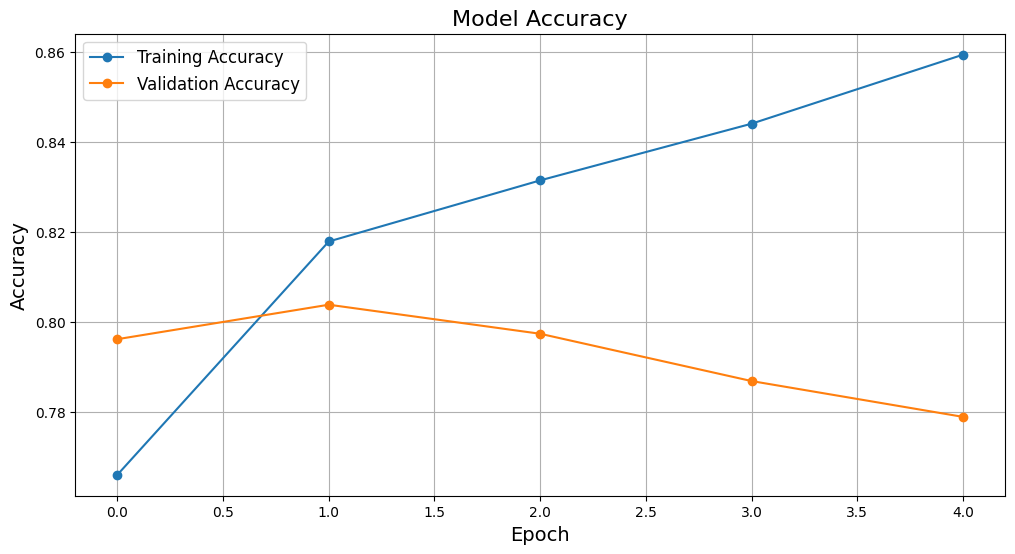

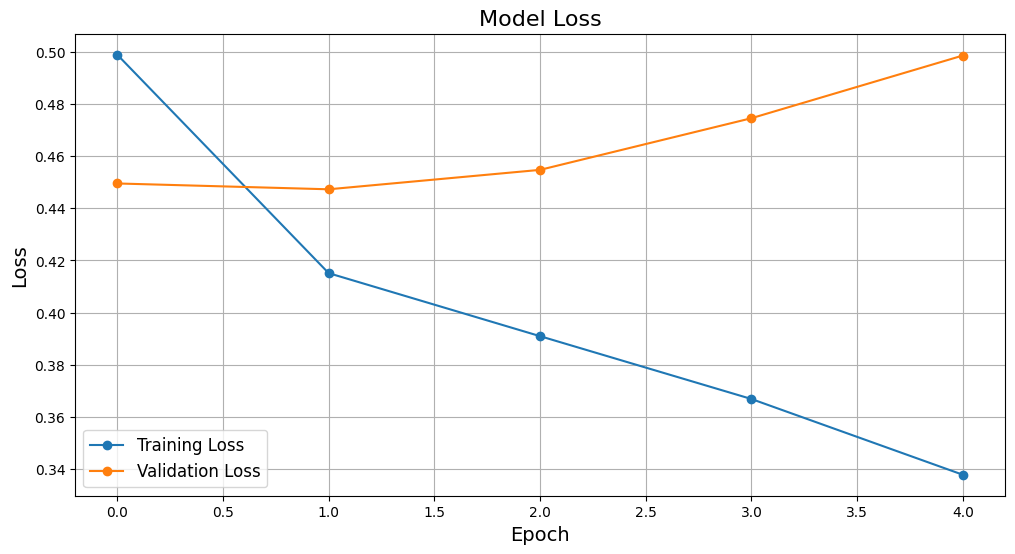

In [20]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama metriklerini gru_results'tan al
history = gru_results.history

# Accuracy grafiği
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Loss grafiği
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [21]:
#gru.save("gru_model.h5")

In [22]:
model3_test_start = time.time()
gru_pred_test = gru.predict(X_test_tokenizer)
model3_test_end = time.time()
model3_test_time = model3_test_end - model3_test_start
print("Model3 Test Time = ", model3_test_time)

521/521 [==============================] - 5s 8ms/step
Model3 Test Time =  4.857178211212158


In [23]:
gru_pred_train = gru.predict(X_train_tokenizer)
gru_pred_train = [np.argmax(pred) for pred in gru_pred_train]
gru_pred_test = [np.argmax(pred) for pred in gru_pred_test]
gru_train_score = accuracy_score(gru_pred_train, y_train)
gru_test_score = accuracy_score(gru_pred_test, y_test)
print(f"GRU Train Score = {gru_train_score * 100:.2f}%")
print(f"GRU Test Score = {gru_test_score * 100:.2f}%")

2081/2081 [==============================] - 17s 8ms/step
GRU Train Score = 87.85%
GRU Test Score = 76.97%


In [24]:
gru_precision_score = precision_score(y_test, gru_pred_test)
gru_f1_score = f1_score(y_test, gru_pred_test)
gru_recall_score = recall_score(y_test, gru_pred_test)
gru_accuracy_score = accuracy_score(y_test, gru_pred_test)

print(f"GRU Precision Score = {gru_precision_score * 100:.2f}%")
print(f"GRU F1 Score = {gru_f1_score * 100:.2f}%")
print(f"GRU Recall Score = {gru_recall_score * 100:.2f}%")
print(f"GRU Accuracy Score = {gru_accuracy_score * 100:.2f}%")

GRU Precision Score = 82.66%
GRU F1 Score = 83.50%
GRU Recall Score = 84.36%
GRU Accuracy Score = 76.97%


In [25]:
print(classification_report(y_test, gru_pred_test))

              precision    recall  f1-score   support

           0       0.63      0.60      0.62      5148
           1       0.83      0.84      0.84     11498

    accuracy                           0.77     16646
   macro avg       0.73      0.72      0.73     16646
weighted avg       0.77      0.77      0.77     16646



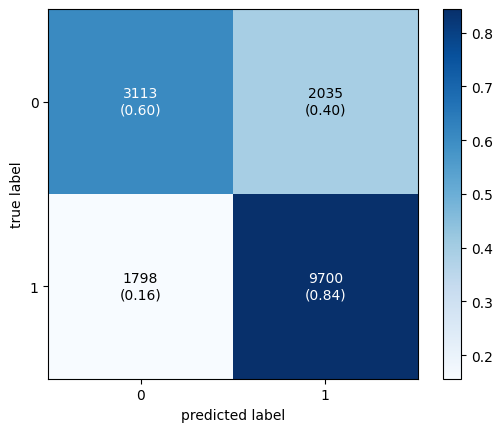

In [26]:
gru_cm = confusion_matrix(y_test, gru_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=gru_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()